In [1]:
import scanpy as sc
adata_hvg = sc.read("data/dataset_glutamatergic_latest_state.h5ad")

In [2]:
import pertpy as pt

milo = pt.tl.Milo()
mdata = milo.load(adata_hvg)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
neighbours = 46 * 5
sc.pp.neighbors(adata_hvg, n_neighbors=neighbours, use_rep="X_scVI", key_added="milo")

In [4]:
import numpy as np

milo.make_nhoods(mdata, neighbors_key="milo", prop=0.03)
adata_hvg.obsm["nhoods"]
nhood_size = adata_hvg.obsm["nhoods"].toarray().sum(0)
np.median(nhood_size)

np.float32(420.0)

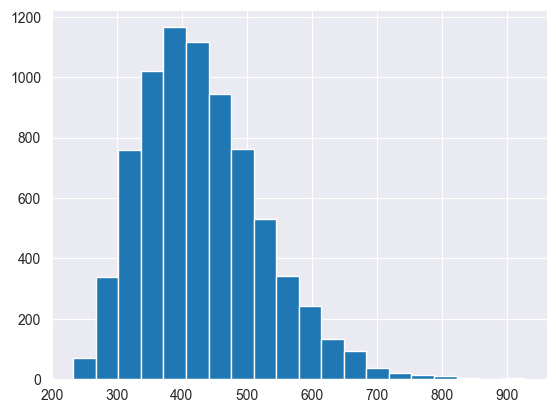

In [5]:
import matplotlib.pyplot as plt
plt.hist(nhood_size, bins=20)
plt.show()

In [6]:
milo.count_nhoods(mdata, sample_col="donor_id")

MuData object with n_obs × n_vars = 282930 × 5000
  2 modalities
    rna:	282930 x 5000
      obs:	'APOE_class', 'Brain.Region', 'SORT', 'Braak.stage', 'Disease.Group', 'Amyloid', 'Brain.weight', 'PMI.hr.', 'Race', 'Age', 'RIN', 'total_counts', 'pct_counts_mt', 'droplet_FDR', 'doublefinder', 'n_genes', 'sample', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'donor_id', 'Age_group', 'PMI_group', 'RIN_group', 'Major_celltypes', 'Author_Annotation', 'NP.Diagonis', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'mt', 'ribo', 'hb', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'Author_Annotation_colors', 'cell_type_colors', 'citation', 'disease_colors', 'donor_id_colors', 'hvg', 'neighbors', 'nhood_neighbors_key', 'organism', 'organism_ontology_term_id', 'pca', 'schema_reference', 'schema_version', 'title', 'umap', 'milo'
      obsm:	'X_pca', 'X_pca_harmony', 'X_scVI', 'X_umap', 'nhoods'
      varm:	'PCs'
      layers:	'counts', 'spliced', 'unspliced'
      obsp:	'connectivities', 'distances', 'milo_distances', 'milo_connectivities'
    milo:	46 x 7609
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

Text(0, 0.5, 'Mean # cells per sample in nhood')

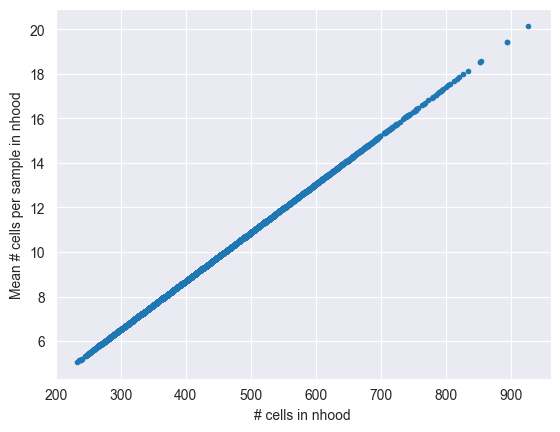

In [7]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [8]:
adata_hvg.obs["disease"].value_counts()

disease
Alzheimer disease    207990
normal                74940
Name: count, dtype: int64

In [9]:
adata_hvg.obs["disease"].unique()
adata_hvg.obs["disease"] = adata_hvg.obs["disease"].str.replace(" ", "_")


Error importing in API mode: ImportError("dlopen(/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <21BE8260-F4D5-3597-9DD0-6953BC4DDF3D> /Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


               disease donor_id
12   Alzheimer_disease       12
14   Alzheimer_disease       14
18   Alzheimer_disease       18
19   Alzheimer_disease       19
24   Alzheimer_disease       24
30   Alzheimer_disease       30
32   Alzheimer_disease       32
33   Alzheimer_disease       33
35   Alzheimer_disease       35
42   Alzheimer_disease       42
44   Alzheimer_disease       44
45   Alzheimer_disease       45
46   Alzheimer_disease       46
49              normal       49
50              normal       50
52   Alzheimer_disease       52
57   Alzheimer_disease       57
59   Alzheimer_disease       59
60   Alzheimer_disease       60
68   Alzheimer_disease       68
69   Alzheimer_disease       69
71              normal       71
73   Alzheimer_disease       73
74   Alzheimer_disease       74
75   Alzheimer_disease       75
76   Alzheimer_disease       76
91              normal       91
92   Alzheimer_disease       92
94              normal       94
95              normal       95
103     

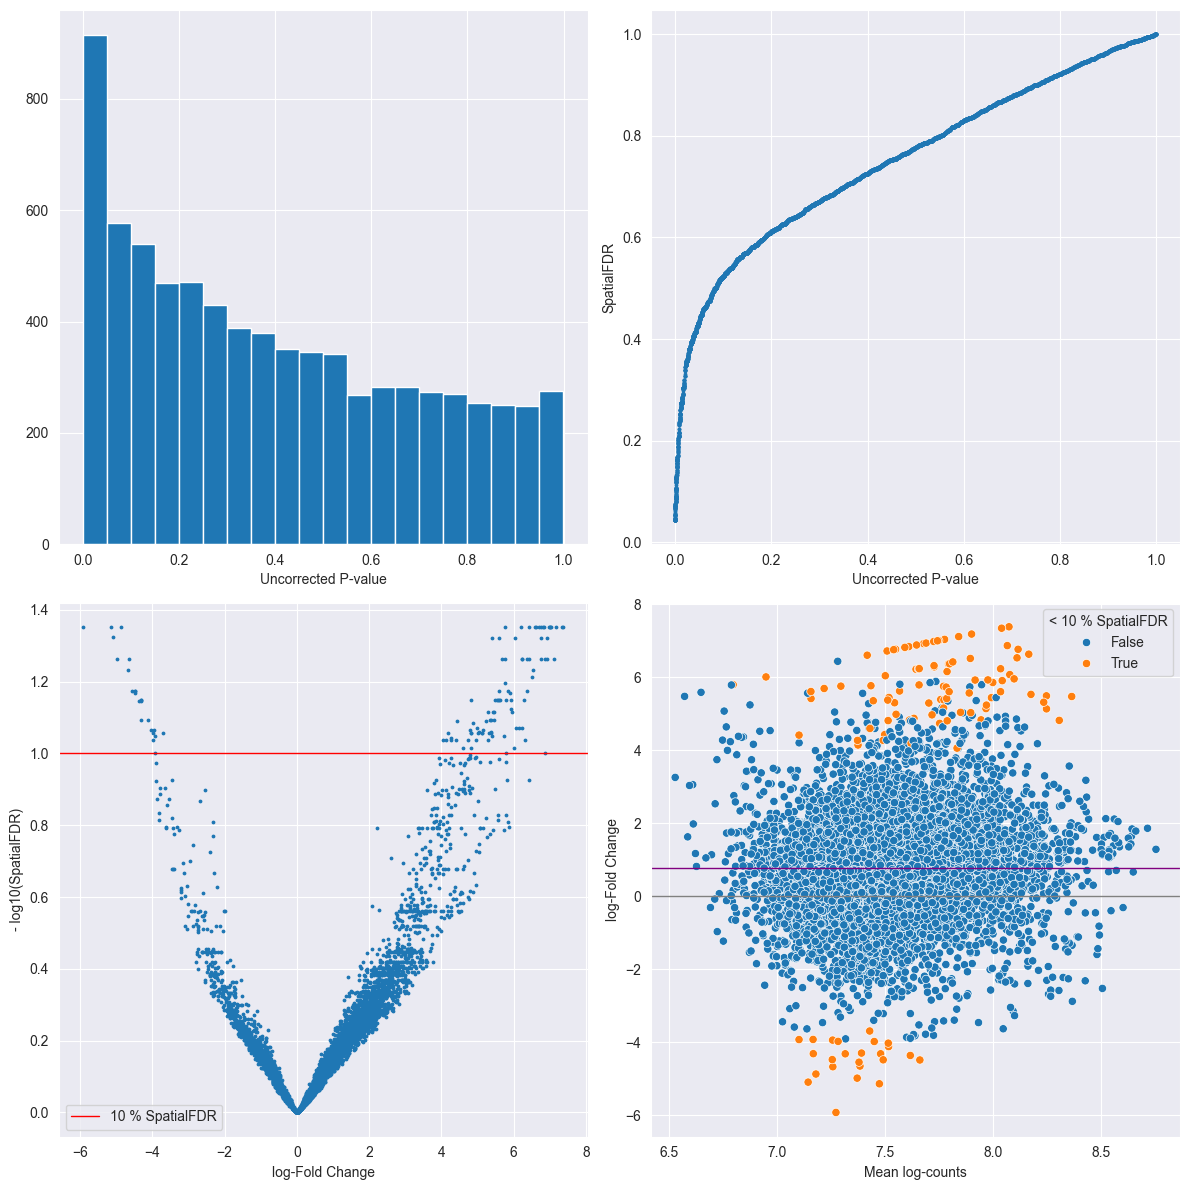

In [10]:
import matplotlib
import seaborn as sns

milo.da_nhoods(
    mdata,
    design="~disease",
    model_contrasts="diseaseAlzheimer_disease - diseasenormal"
)

ds = mdata["milo"].obs.copy()
print(ds)
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):
        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


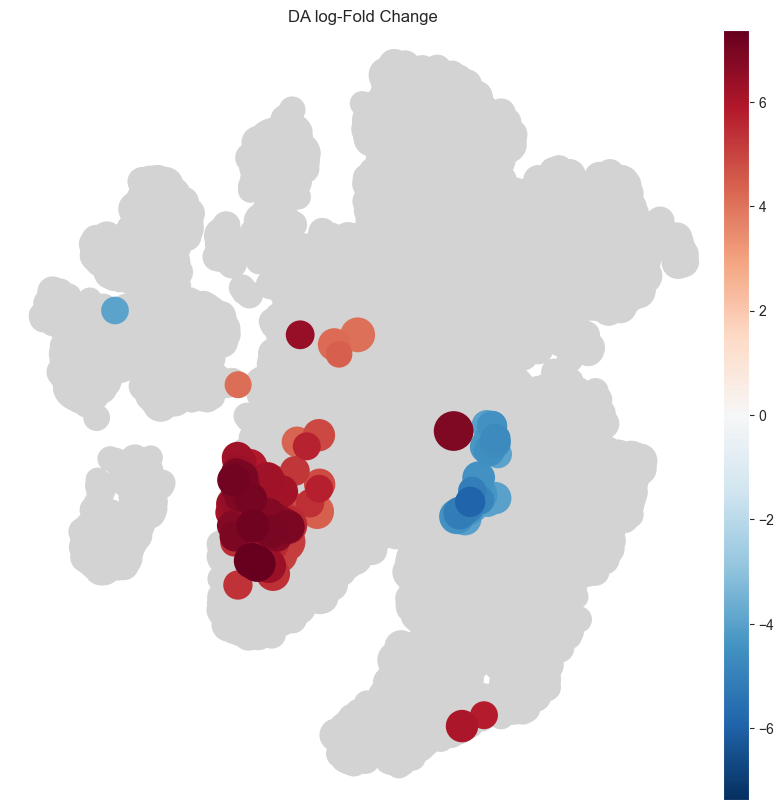

In [11]:
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [10, 10]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)

In [12]:
mdata["milo"]

AnnData object with n_obs × n_vars = 46 × 7609
    obs: 'disease', 'donor_id'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'adjust.method', 'comparison', 'test', 'SpatialFDR', 'Sig', 'Nhood_size'
    uns: 'sample_col', 'nhood'
    varm: 'X_milo_graph'
    varp: 'nhood_connectivities'

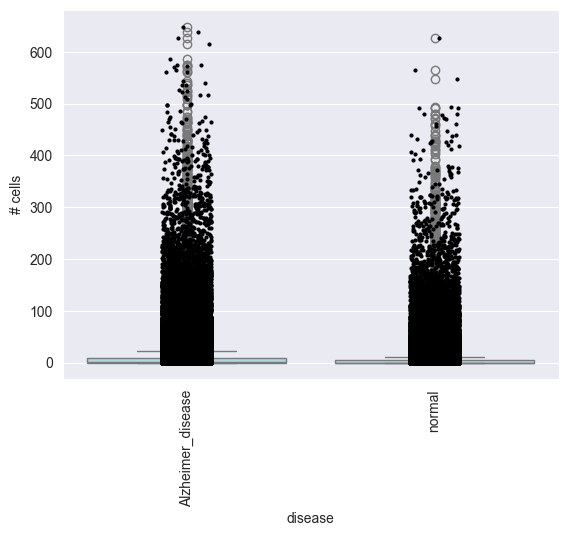

In [13]:
milo.plot_nhood_counts_by_cond(mdata, "disease")

In [70]:
significant_cells = mdata["milo"].var[mdata['milo'].var["SpatialFDR"] < 0.1]
significant_cells

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,adjust.method,comparison,test,SpatialFDR,Sig,Nhood_size
2,ACTTGTTTCTTAGCCC-C0017,1.517851,-3.932415,7.100914,11.068743,0.001060,0.082413,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.089121,True,318.0
1386,GAGGTTAGCGAA-D0014,1.153645,5.384416,7.757899,12.035818,0.000701,0.074061,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.080771,True,479.0
1408,AGCACGCCCCCA-D0029,1.410668,5.761451,7.434351,14.430049,0.000220,0.049064,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.054581,True,336.0
1680,ATCAAGATATAA-D0096,1.810355,4.137394,7.374472,10.867679,0.001205,0.084873,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.091966,True,303.0
1840,GAAAAGCGTGAG-D0164,1.573517,6.426119,7.277830,18.897833,0.000027,0.040962,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.044372,True,344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532,TGGTTTGCCAAC-D0039,1.103379,5.598329,8.035424,13.381609,0.000367,0.060403,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.067133,True,563.0
7590,AGATTTCTCACA-D0170,1.098512,5.024361,7.896956,11.278175,0.001007,0.081085,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.087451,True,531.0
7596,ACGTGGAAGGTC-D0187,1.103275,5.949595,8.098172,12.396049,0.000601,0.070246,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.076537,True,618.0
7601,ATGCTTCTCCCA-D0187,1.182042,6.972801,7.725631,16.894366,0.000072,0.040962,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.044372,True,478.0


In [71]:
import pandas as pd

cluster_index =significant_cells.index

df_sparse = pd.DataFrame.sparse.from_spmatrix(
    adata_hvg.obsm["nhoods"],
    index=adata_hvg.obs_names,
    columns=[f"{i}" for i in range(adata_hvg.obsm["nhoods"].shape[1])]
)

In [75]:
for idx in cluster_index:
    items = df_sparse[df_sparse[idx] == 1]
    adata_hvg[items.index].write(f"data/significant_subpopulations/cluster" + idx + ".h5ad")

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/

In [106]:
significant_cells

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,adjust.method,comparison,test,SpatialFDR,Sig,Nhood_size
2,ACTTGTTTCTTAGCCC-C0017,1.517851,-3.932415,7.100914,11.068743,0.001060,0.082413,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.089121,True,318.0
1386,GAGGTTAGCGAA-D0014,1.153645,5.384416,7.757899,12.035818,0.000701,0.074061,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.080771,True,479.0
1408,AGCACGCCCCCA-D0029,1.410668,5.761451,7.434351,14.430049,0.000220,0.049064,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.054581,True,336.0
1680,ATCAAGATATAA-D0096,1.810355,4.137394,7.374472,10.867679,0.001205,0.084873,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.091966,True,303.0
1840,GAAAAGCGTGAG-D0164,1.573517,6.426119,7.277830,18.897833,0.000027,0.040962,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.044372,True,344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532,TGGTTTGCCAAC-D0039,1.103379,5.598329,8.035424,13.381609,0.000367,0.060403,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.067133,True,563.0
7590,AGATTTCTCACA-D0170,1.098512,5.024361,7.896956,11.278175,0.001007,0.081085,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.087451,True,531.0
7596,ACGTGGAAGGTC-D0187,1.103275,5.949595,8.098172,12.396049,0.000601,0.070246,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.076537,True,618.0
7601,ATGCTTCTCCCA-D0187,1.182042,6.972801,7.725631,16.894366,0.000072,0.040962,BH,1*diseaseAlzheimer_disease -1*diseasenormal,glm,0.044372,True,478.0


In [126]:
selected_significant_cells = adata_hvg[significant_cells["index_cell"]]
selected_significant_cells.obs["cluster_index"] = significant_cells.index.astype('category')

/var/folders/m0/5342p_s55313vrcn64gwp8t80000gn/T/ipykernel_68883/3201172282.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  selected_significant_cells.obs["cluster_index"] = significant_cells.index.astype('category')


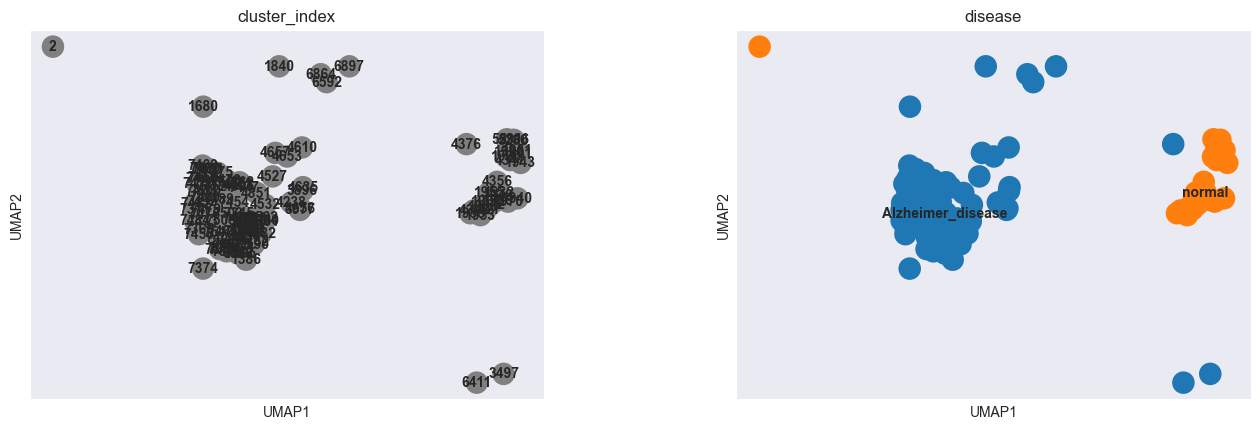

In [129]:
sc.pl.umap(selected_significant_cells, color=["cluster_index", "disease"], ncols=3, wspace=0.25, legend_loc="on data")

In [123]:
selected_significant_cells.obs["cluster_index"]

ACTTGTTTCTTAGCCC-C0017       2
GAGGTTAGCGAA-D0014        1386
AGCACGCCCCCA-D0029        1408
ATCAAGATATAA-D0096        1680
GAAAAGCGTGAG-D0164        1840
                          ... 
TGGTTTGCCAAC-D0039        7532
AGATTTCTCACA-D0170        7590
ACGTGGAAGGTC-D0187        7596
ATGCTTCTCCCA-D0187        7601
TAGTTTCAGGAT-D0187        7605
Name: cluster_index, Length: 114, dtype: object

In [125]:
significant_cells.index

Index(['2', '1386', '1408', '1680', '1840', '1926', '1927', '1929', '1932',
       '1933',
       ...
       '7505', '7511', '7513', '7515', '7531', '7532', '7590', '7596', '7601',
       '7605'],
      dtype='object', length=114)